📤 Please upload your 3 zip files (High.zip, Low.zip, Medium.zip):


In [3]:
# ===== 1. SETUP & DATA PREP =====
# Install system dependencies first
!apt-get update -qq
!apt-get install -y poppler-utils

# Then install Python package
!pip install pdf2image

import os, shutil, pathlib
from pdf2image import convert_from_path
import zipfile
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Define paths for your THREE separate zip files
HIGH_ZIP = "/content/High.zip"
LOW_ZIP = "/content/Low.zip"
MEDIUM_ZIP = "/content/Medium.zip"

RAW_DIR = "/content/raw_complexity"
IMG_DIR = "/content/img_complexity"

# Create base directories
!mkdir -p {RAW_DIR}
!mkdir -p {IMG_DIR}

# Unzip each file into its respective class folder
print("📦 Extracting High.zip...")
with zipfile.ZipFile(HIGH_ZIP, 'r') as zip_ref:
    zip_ref.extractall(f"{RAW_DIR}/Hard")  # High complexity = Hard

print("📦 Extracting Low.zip...")
with zipfile.ZipFile(LOW_ZIP, 'r') as zip_ref:
    zip_ref.extractall(f"{RAW_DIR}/Easy")  # Low complexity = Easy

print("📦 Extracting Medium.zip...")
with zipfile.ZipFile(MEDIUM_ZIP, 'r') as zip_ref:
    zip_ref.extractall(f"{RAW_DIR}/Medium")

# Check structure
print("\n📂 Folder structure:")
!ls -la {RAW_DIR}

# Setup directories as Path objects
RAW_DIR = pathlib.Path(RAW_DIR)
IMG_DIR = pathlib.Path(IMG_DIR)

# Classes we expect
classes = ["Easy", "Medium", "Hard"]

# Convert PDFs -> PNGs (first page only) into IMG_DIR/Easy, IMG_DIR/Medium, IMG_DIR/Hard
print("\n🔄 Converting PDFs to images...")
for cls in classes:
    src_cls_dir = RAW_DIR / cls
    if not src_cls_dir.exists():
        print(f"⚠️ Folder {src_cls_dir} not found!")
        continue

    dst_cls_dir = IMG_DIR / cls
    dst_cls_dir.mkdir(exist_ok=True, parents=True)

    file_count = 0
    for f in src_cls_dir.rglob("*"):  # rglob to search recursively
        if not f.is_file():
            continue

        stem = f.stem

        if f.suffix.lower() == ".pdf":
            try:
                pages = convert_from_path(str(f), dpi=200)
                out_path = dst_cls_dir / f"{stem}.png"
                pages[0].save(out_path)
                file_count += 1
            except Exception as e:
                print(f"❌ Error converting {f.name}: {e}")
        elif f.suffix.lower() in [".png", ".jpg", ".jpeg"]:
            # Already an image, just copy
            shutil.copy(str(f), str(dst_cls_dir / f.name))
            file_count += 1

    print(f"✅ {cls}: {file_count} files processed")

print("\n✅ Conversion done!")
print("📊 Final image distribution:")

# Count and store class distribution for later use
class_counts = {}
for cls in classes:
    cls_dir = IMG_DIR / cls
    if cls_dir.exists():
        num_files = len(list(cls_dir.glob("*.png"))) + len(list(cls_dir.glob("*.jpg")))
        class_counts[cls] = num_files
        print(f"   {cls}: {num_files} images")

# Calculate class imbalance
total_images = sum(class_counts.values())
print(f"\n📈 Total images: {total_images}")
print("Class distribution:")
for cls, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f"   {cls}: {percentage:.1f}%")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.
📦 Extracting High.zip...
📦 Extracting Low.zip...
📦 Extracting Medium.zip...

📂 Folder structure:
total 20
drwxr-xr-x 5 root root 4096 Dec 18 06:54 .
drwxr-xr-x 1 root root 4096 Dec 18 06:50 ..
drwxr-xr-x 3 root root 4096 Dec 18 06:54 Easy
drwxr-xr-x 3 root root 4096 Dec 18 06:54 Hard
drwxr-xr-x 3 root root 4096 Dec 18 06:54 Medium

🔄 Converting PDFs to images...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (123999690 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (123999690 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Easy: 700 files processed
✅ Medium: 391 files processed
✅ Hard: 206 files processed

✅ Conversion done!
📊 Final image distribution:
   Easy: 700 images
   Medium: 391 images
   Hard: 206 images

📈 Total images: 1297
Class distribution:
   Easy: 54.0%
   Medium: 30.1%
   Hard: 15.9%


In [4]:
# ===== 2. DATASET PIPELINE WITH CLASS BALANCING =====
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Increased from 8 for better gradient estimates
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int"
)

class_names = train_ds.class_names
print("Classes:", class_names)

# CRITICAL: Calculate class weights to handle imbalance
# This ensures the model doesn't just predict the majority class (Low/Easy)
from sklearn.utils.class_weight import compute_class_weight

# Get all labels from training set
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)

# Compute class weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print("\n⚖️ Class weights (to handle imbalance):")
for i, name in enumerate(class_names):
    print(f"   {name}: {class_weights[i]:.2f}")

AUTOTUNE = tf.data.AUTOTUNE

# Enhanced augmentation to prevent overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),  # Added vertical flip
    layers.RandomRotation(0.1),     # Increased rotation
    layers.RandomZoom(0.15),        # Increased zoom
    layers.RandomContrast(0.2),     # Increased contrast variation
    layers.RandomBrightness(0.2),   # Added brightness variation
], name="augmentation")

def preprocess(x, y):
    x = data_augmentation(x, training=True)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x, y

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y),
                     num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

print("\n✅ Dataset pipeline ready with balanced class weights")

Found 1297 files belonging to 3 classes.
Using 1038 files for training.
Found 1297 files belonging to 3 classes.
Using 259 files for validation.
Classes: ['Easy', 'Hard', 'Medium']

⚖️ Class weights (to handle imbalance):
   Easy: 0.61
   Hard: 2.10
   Medium: 1.13

✅ Dataset pipeline ready with balanced class weights


In [5]:
# ===== 3. MODEL: RESNET50 WITH REGULARIZATION =====

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg"
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)

# Add stronger regularization to prevent overfitting
x = layers.Dropout(0.5)(x)  # Increased from 0.3
x = layers.Dense(128, activation="relu")(x)  # Added intermediate layer
x = layers.Dropout(0.3)(x)  # Additional dropout
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

print("\n🔧 Model built with regularization to prevent overfitting")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


🔧 Model built with regularization to prevent overfitting


In [6]:
# ===== 4. INITIAL TRAINING (FROZEN BASE) =====

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Changed to val_loss for better generalization
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    )
]

print(" Starting initial training with frozen base...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,  # CRITICAL: Use class weights
    verbose=1
)

print("\n Initial training complete")

🚀 Starting initial training with frozen base...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.5965 - loss: 1.3463 - val_accuracy: 0.6718 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.7094 - loss: 0.7215 - val_accuracy: 0.6564 - val_loss: 0.5921 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6843 - loss: 0.7464 - val_accuracy: 0.7876 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7558 - loss: 0.6365 - val_accuracy: 0.7452 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.7759 - loss: 0.6226 - val_accuracy: 0.8069 - val_loss: 0.4321 - learning_rate: 0.0010
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.7553 - loss: 0.6165 - val_accuracy: 0.6757 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/

In [7]:
# ===== 5. FINE-TUNING LAST LAYERS =====

# Unfreeze the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with much lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Very low LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(" Unfroze last 30 layers for fine-tuning")

callbacks_finetune = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    )
]

print(" Starting fine-tuning...")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_finetune,
    class_weight=class_weights,  # Still use class weights
    verbose=1
)

print("\n Fine-tuning complete")

 Unfroze last 30 layers for fine-tuning
 Starting fine-tuning...
Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.7107 - loss: 1.5190 - val_accuracy: 0.8185 - val_loss: 0.4181 - learning_rate: 1.0000e-05
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7835 - loss: 0.9144 - val_accuracy: 0.8494 - val_loss: 0.4273 - learning_rate: 1.0000e-05
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7713 - loss: 0.8468
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
65/65 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.7716 - loss: 0.8454 - val_accuracy: 0.8340 - val_loss: 0.4400 - learning_rate: 1.0000e-05
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.7739 - loss: 0.6846 - val_accuracy: 0.8340 - val_loss: 0.4574 - learning_rate: 3.0000e-06
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8043 - loss: 0.6387
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999636216671e-07.
65/65 ━


📊 Final Validation Metrics:
   Loss: 0.4181
   Accuracy: 0.8185

📋 Detailed Classification Report:
              precision    recall  f1-score   support

        Easy       0.95      1.00      0.97       132
        Hard       0.45      0.34      0.39        41
      Medium       0.74      0.77      0.75        86

    accuracy                           0.82       259
   macro avg       0.71      0.70      0.71       259
weighted avg       0.80      0.82      0.81       259



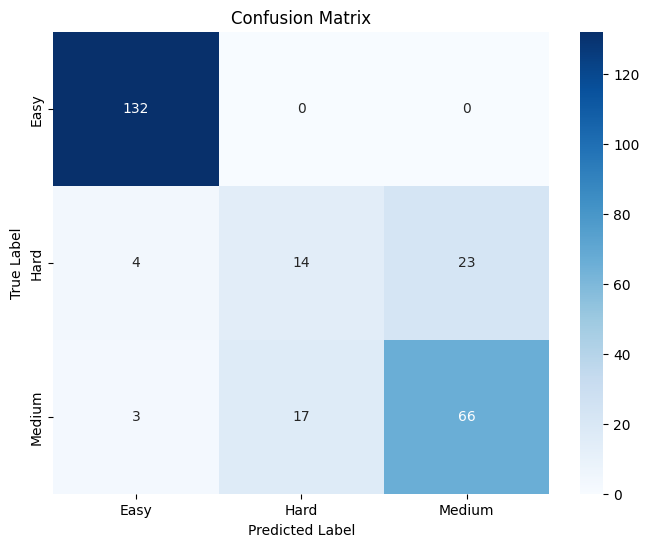

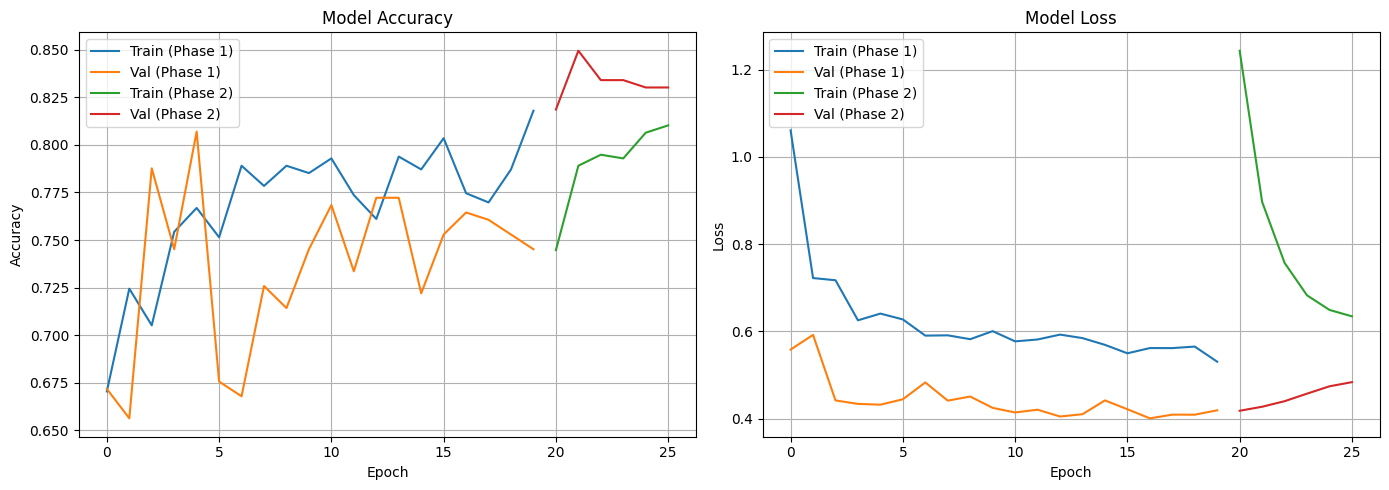


 Overfitting Check:
   Final Training Loss: 0.6346
   Final Validation Loss: 0.4837
   Difference: 0.1509
    Slight overfitting detected


In [8]:
# ===== 6. DETAILED EVALUATION =====

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"\n📊 Final Validation Metrics:")
print(f"   Loss: {val_loss:.4f}")
print(f"   Accuracy: {val_acc:.4f}")

# Get predictions for confusion matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history1.history['accuracy'], label='Train (Phase 1)')
ax1.plot(history1.history['val_accuracy'], label='Val (Phase 1)')
if history2:
    offset = len(history1.history['accuracy'])
    ax1.plot(range(offset, offset + len(history2.history['accuracy'])),
             history2.history['accuracy'], label='Train (Phase 2)')
    ax1.plot(range(offset, offset + len(history2.history['val_accuracy'])),
             history2.history['val_accuracy'], label='Val (Phase 2)')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history1.history['loss'], label='Train (Phase 1)')
ax2.plot(history1.history['val_loss'], label='Val (Phase 1)')
if history2:
    offset = len(history1.history['loss'])
    ax2.plot(range(offset, offset + len(history2.history['loss'])),
             history2.history['loss'], label='Train (Phase 2)')
    ax2.plot(range(offset, offset + len(history2.history['val_loss'])),
             history2.history['val_loss'], label='Val (Phase 2)')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Check for overfitting
train_loss = history2.history['loss'][-1] if history2 else history1.history['loss'][-1]
val_loss_final = history2.history['val_loss'][-1] if history2 else history1.history['val_loss'][-1]

print(f"\n Overfitting Check:")
print(f"   Final Training Loss: {train_loss:.4f}")
print(f"   Final Validation Loss: {val_loss_final:.4f}")
print(f"   Difference: {abs(train_loss - val_loss_final):.4f}")

if abs(train_loss - val_loss_final) < 0.1:
    print("    Model is well-balanced (minimal overfitting)")
elif abs(train_loss - val_loss_final) < 0.3:
    print("    Slight overfitting detected")
else:
    print("    Significant overfitting - consider more regularization")

In [10]:
# ===== 7. SAVE MODEL (FIXED) =====
import json
import os

# 1) Recommended Keras format
KERAS_PATH = "/content/resnet50_complexity.keras"
model.save(KERAS_PATH)
print(f"✅ Saved model to: {KERAS_PATH}")

# 2) Optional legacy H5 (works for many Streamlit loads)
H5_PATH = "/content/resnet50_complexity.h5"
model.save(H5_PATH)
print(f"✅ Saved model to: {H5_PATH}")

# 3) Export SavedModel folder (for TF Serving / TFLite pipelines)
SAVEDMODEL_DIR = "/content/resnet50_complexity_savedmodel"
model.export(SAVEDMODEL_DIR)   # <-- IMPORTANT: use export()
print(f"✅ Exported SavedModel to folder: {SAVEDMODEL_DIR}")

# 4) Save class info
class_info = {
    "class_names": class_names,
    "class_weights": {str(k): float(v) for k, v in class_weights.items()},
    "hours_map": {
        "Easy": 3.0,
        "Medium": 6.0,
        "Hard": 12.0
    }
}

with open("/content/class_info.json", "w") as f:
    json.dump(class_info, f, indent=2)

print("✅ Saved class information: /content/class_info.json")


✅ Saved model to: /content/resnet50_complexity.keras
✅ Saved model to: /content/resnet50_complexity.h5
Saved artifact at '/content/resnet50_complexity_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_183')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  131967309072528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309073296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309074256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309074448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309073680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309073488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309075984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309075792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967309076944: TensorS

📤 Upload your drawing (PDF, PNG, JPG):


Saving 01-13283-BB00-EE0325702_1A_RED_2023-07-18_01.pdf to 01-13283-BB00-EE0325702_1A_RED_2023-07-18_01.pdf

Processing: 01-13283-BB00-EE0325702_1A_RED_2023-07-18_01.pdf


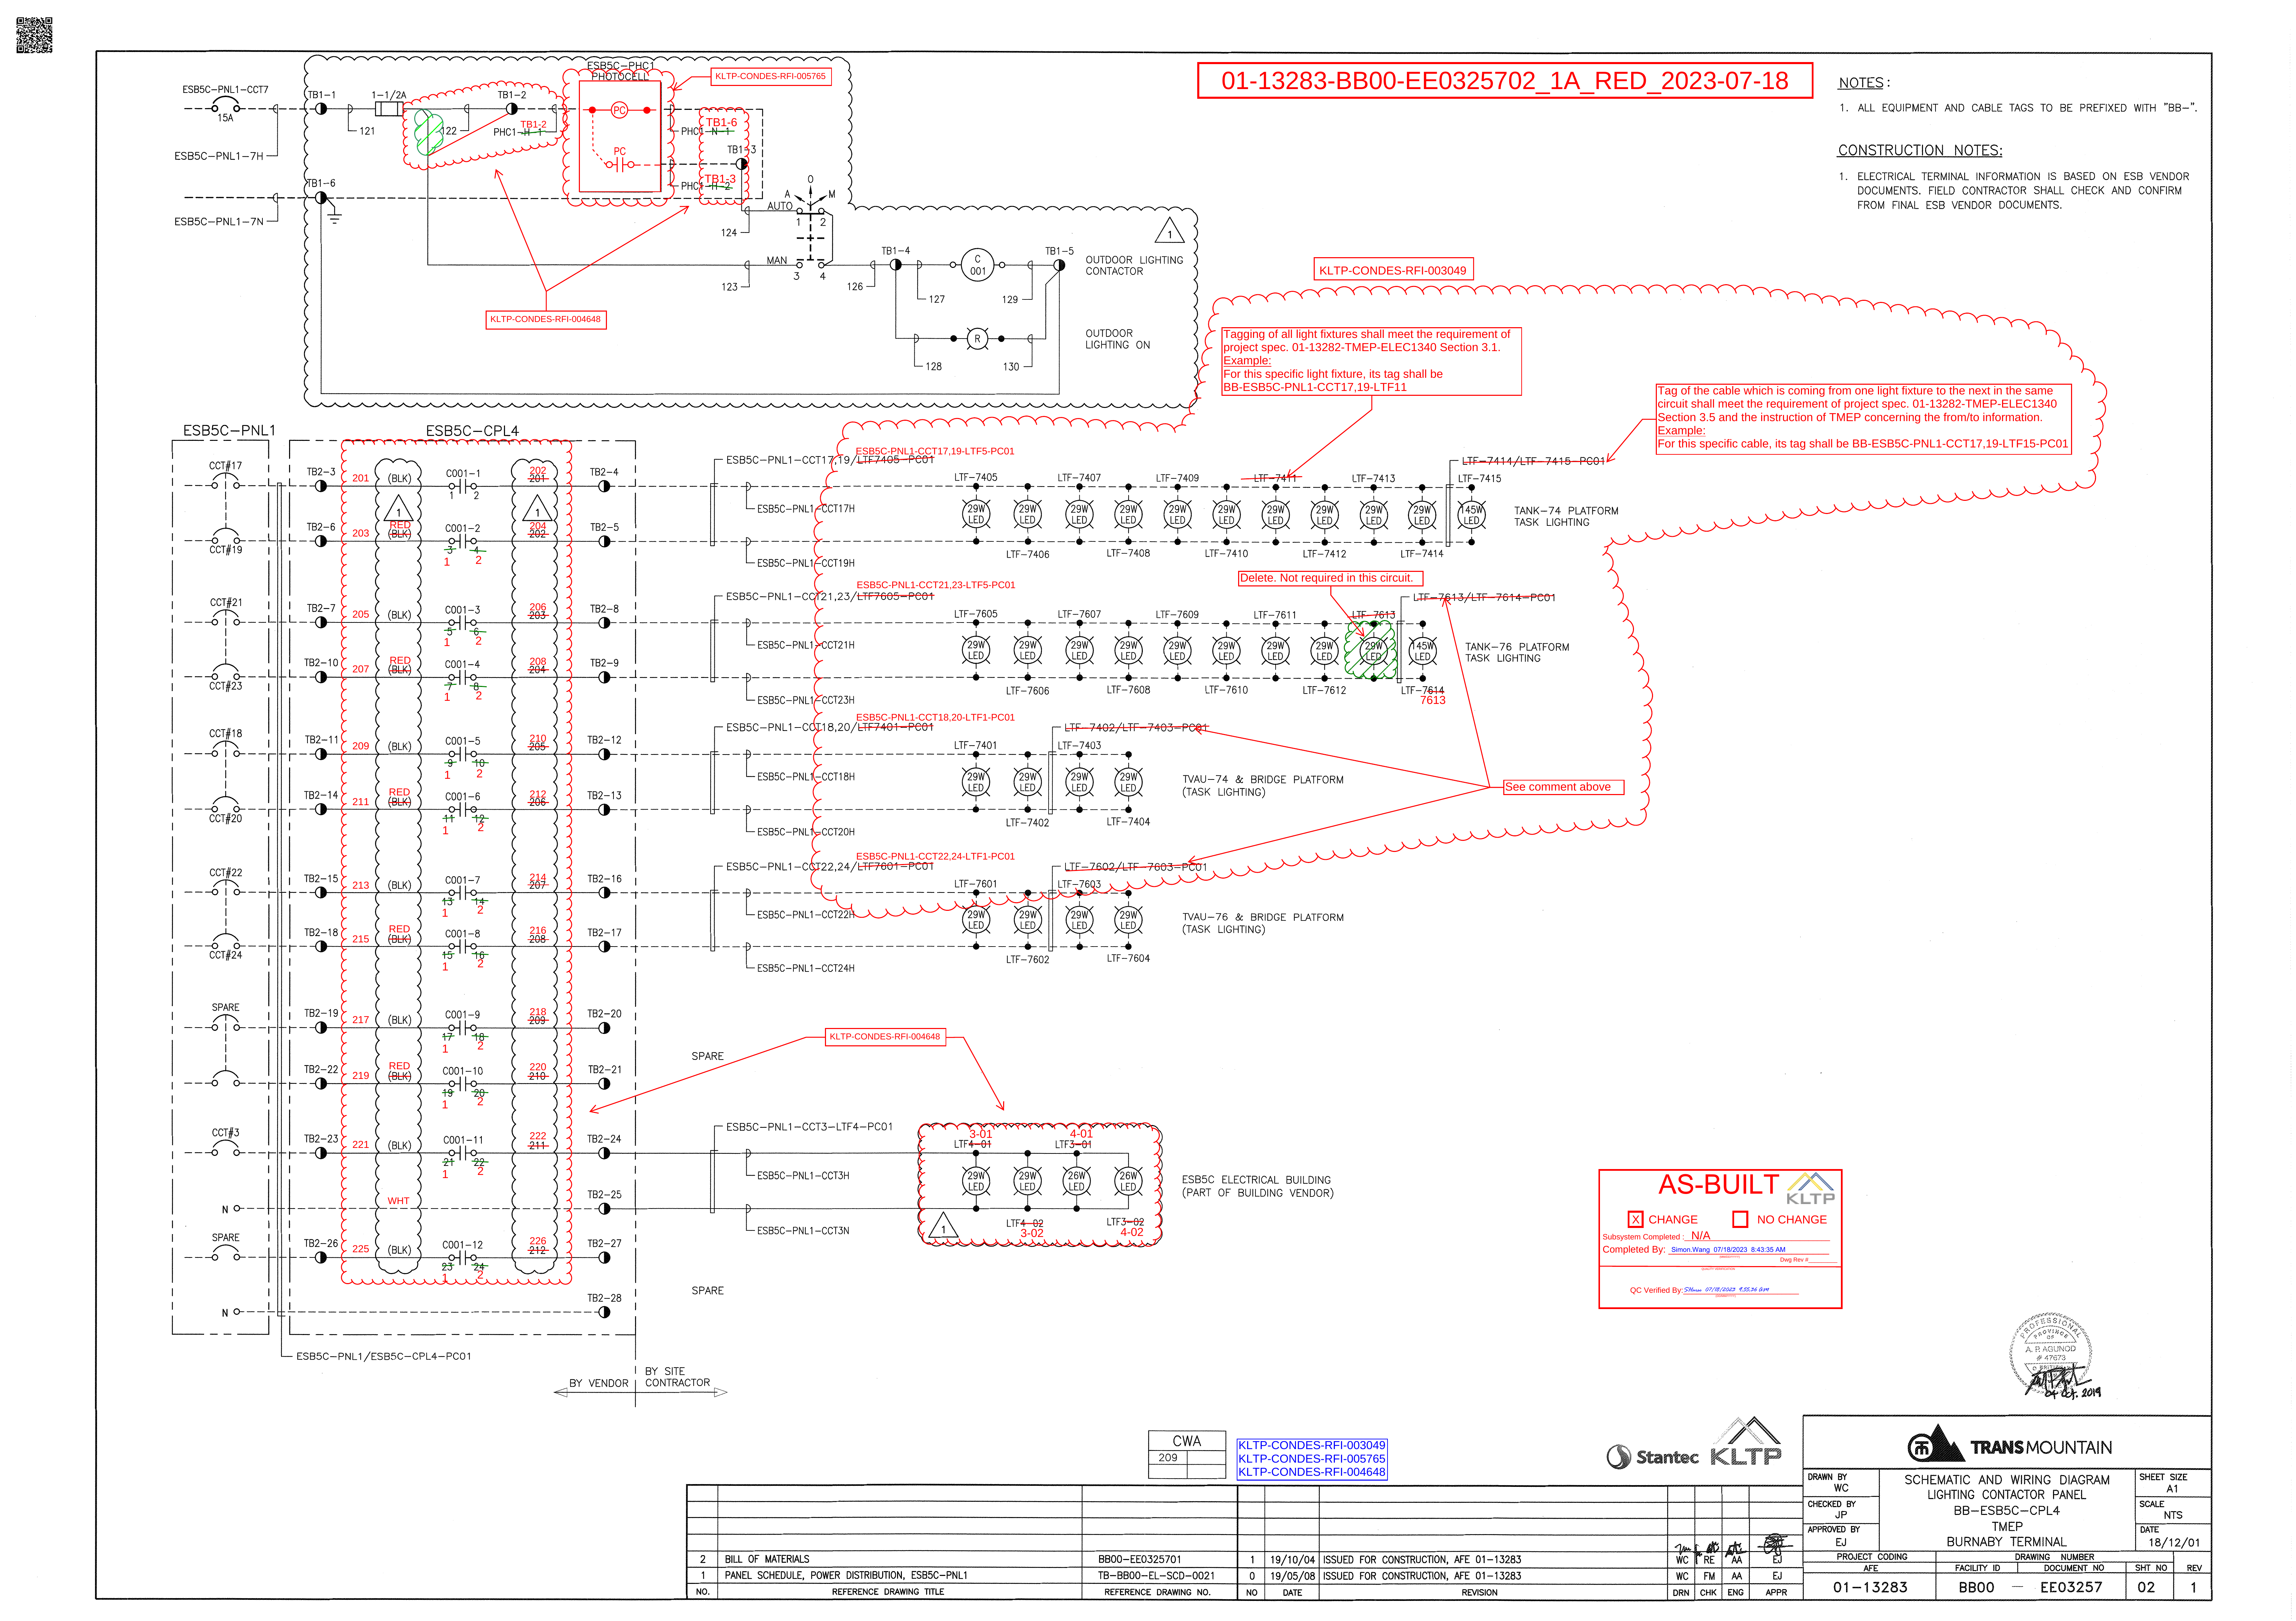


📊 Prediction Results:
   Complexity: Medium
   Confidence: 54.5%
   Estimated Hours: 6.0 hours
   Estimated Cost: $390.00

📈 All class probabilities:
   Easy: 0.3%
   Medium: 54.5%
   Hard: 45.2%


In [11]:
# ===== 8. TEST WITH YOUR OWN IMAGE =====
from google.colab import files
from PIL import Image
import io

CLASS_NAMES = ["Easy", "Medium", "Hard"]
HOURS_MAP = {
    "Easy": 3.0,
    "Medium": 6.0,
    "Hard": 12.0
}
RATE_PER_HOUR = 65.0

def preprocess_image_pil(pil_img, img_size=(224, 224)):
    """Preprocess PIL image for model prediction"""
    pil_img = pil_img.convert("RGB")
    w, h = pil_img.size
    side = max(w, h)

    # Pad to square with white background
    square = Image.new("RGB", (side, side), (255, 255, 255))
    square.paste(pil_img, ((side - w)//2, (side - h)//2))

    # Resize
    square = square.resize(img_size, Image.LANCZOS)

    # Convert to array and preprocess
    arr = np.array(square)
    arr = tf.keras.applications.resnet50.preprocess_input(arr)
    return np.expand_dims(arr, axis=0)

print("📤 Upload your drawing (PDF, PNG, JPG):")
uploaded = files.upload()

for filename, data in uploaded.items():
    print(f"\n{'='*50}")
    print(f"Processing: {filename}")
    print('='*50)

    # Load image
    if filename.lower().endswith(".pdf"):
        from pdf2image import convert_from_bytes
        pages = convert_from_bytes(data)
        pil_img = pages[0]
    else:
        pil_img = Image.open(io.BytesIO(data))

    # Preprocess and predict
    x = preprocess_image_pil(pil_img)
    predictions = model.predict(x, verbose=0)

    cls_idx = int(np.argmax(predictions[0]))
    cls_name = CLASS_NAMES[cls_idx]
    confidence = float(predictions[0][cls_idx])

    hours = HOURS_MAP[cls_name]
    cost = hours * RATE_PER_HOUR

    # Display results
    display(pil_img)
    print(f"\n📊 Prediction Results:")
    print(f"   Complexity: {cls_name}")
    print(f"   Confidence: {confidence:.1%}")
    print(f"   Estimated Hours: {hours:.1f} hours")
    print(f"   Estimated Cost: ${cost:.2f}")

    print(f"\n📈 All class probabilities:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"   {name}: {predictions[0][i]:.1%}")